In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, uniq_opt_tenors, uniq_swap_tenors, uniq_strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
seed = 0 # other seeds provides the same result
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                    seed=seed,
                                                                                    train_ratio=0.8)

data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

### Find best latent space dimension by total loss

1

Mean error 4.51
Max error 109.44


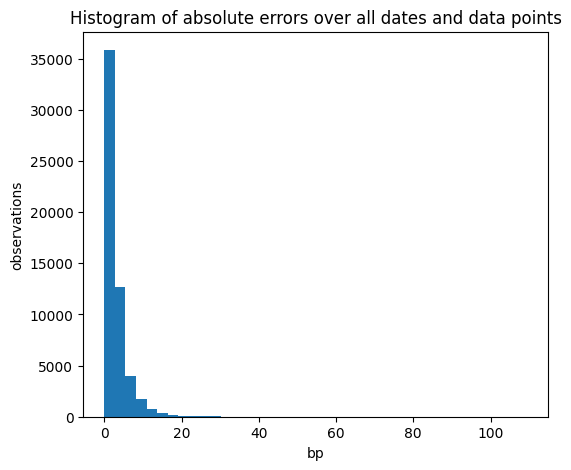

2
Mean error 1.5
Max error 41.42


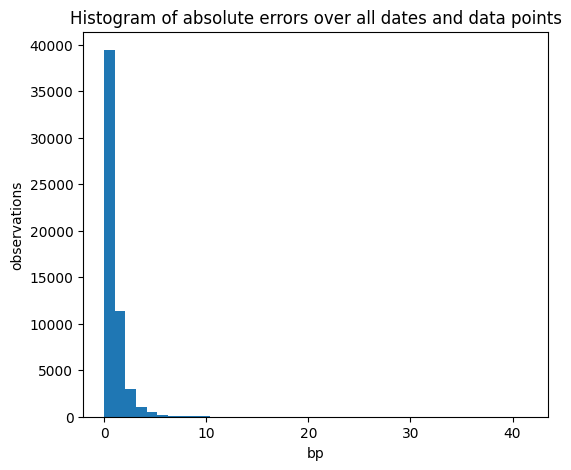

3
Mean error 1.36
Max error 38.72


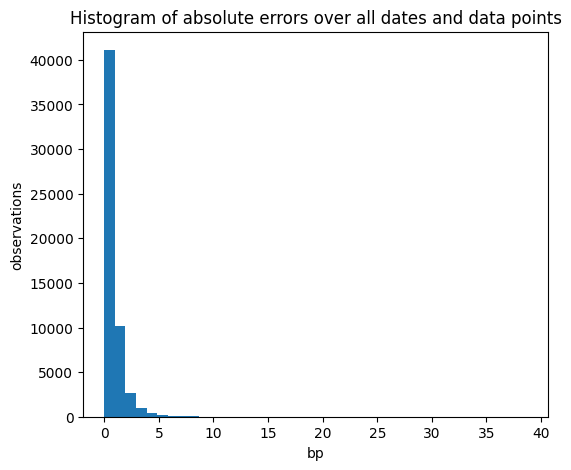

4
Mean error 1.36
Max error 37.45


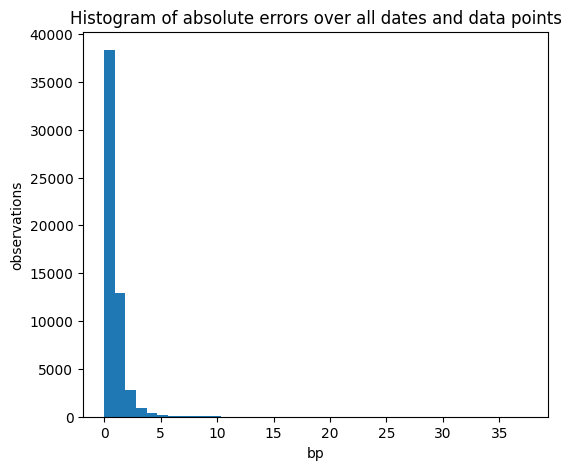

5
Mean error 1.46
Max error 38.69


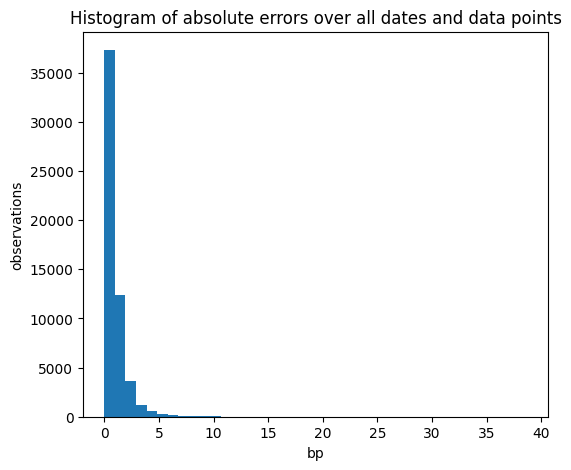

8
Mean error 1.36
Max error 37.83


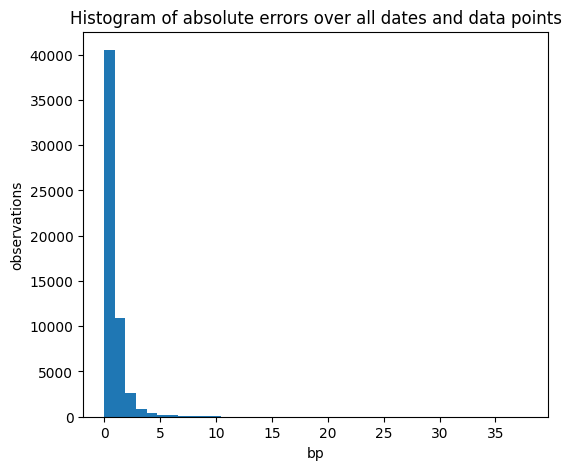

12
Mean error 1.47
Max error 37.56


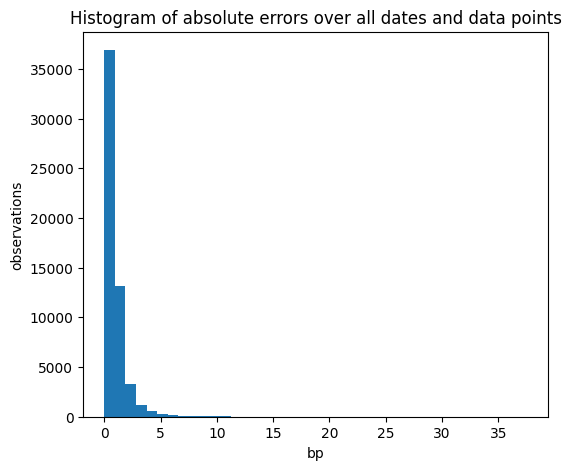

20
Mean error 1.38
Max error 39.22


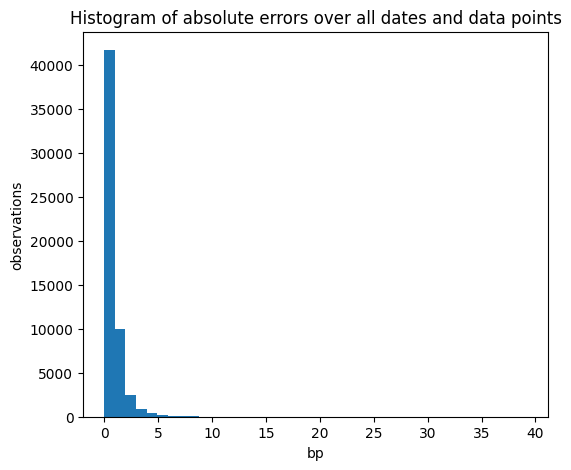

25
Mean error 1.37
Max error 37.24


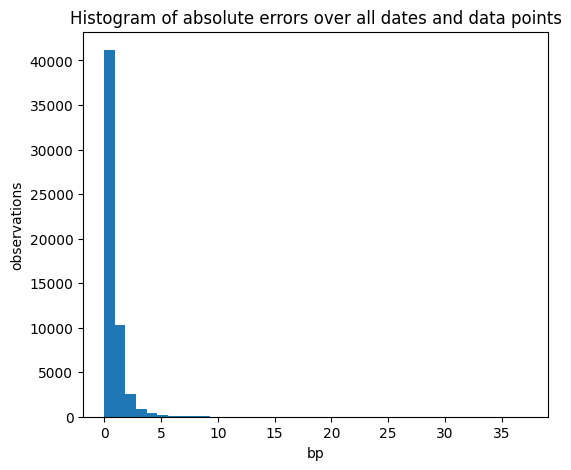

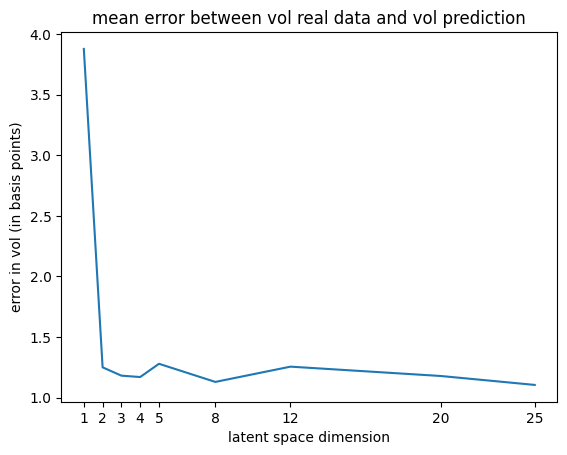

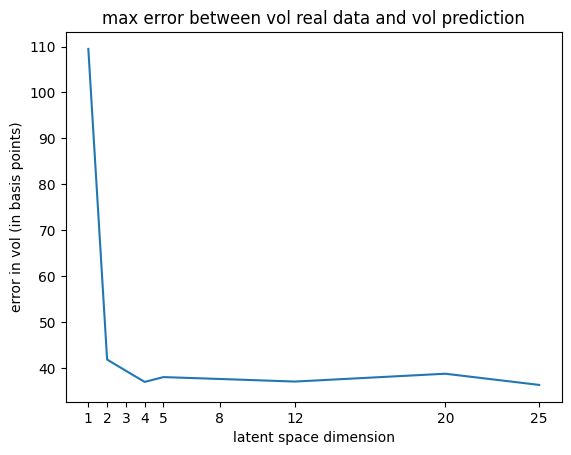

In [2]:
from src.models.vae_vanilla import VaeVanilla
from src.visualization.vol.error_histograms import error_histograms
import numpy as np

lat_space = np.array([1, 2, 3, 4, 5, 8, 12, 20, 25])
errors_mean = []
errors_max = []

for i, lat_val in enumerate(lat_space):
    print(lat_val)
    vae = VaeVanilla(input_shape=data_norm_train.shape[1:],
                     hidden_layers_nodes=[400, 200, 200, 100],
                     latent_space_dim=lat_val,
                     loss_type='mse',
                     beta=2e-6)
    vae.compile(optimizer='adam')
    history = vae.fit(data_norm_train, 
                      epochs=500,
                      batch_size=16,
                      verbose=0,
                      validation_data=data_norm_test)

    predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
    error_histograms(predictions,
                     data_test)

    predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
    avg_errors = np.zeros(len(predictions))
    max_errors = np.zeros(len(predictions))

    for i, val in enumerate(data_test):
        diff = val - predictions[i]
        avg_errors[i] = ((diff**2).mean()**0.5)  # error is deviation from zero (not from mean)
        max_errors[i] = abs(diff).max()  # error is deviation from zero (not from mean)

    errors_mean.append(avg_errors.mean())
    errors_max.append(max_errors.max())

import matplotlib.pyplot as plt

plt.plot(lat_space, errors_mean)
plt.title('mean error between vol real data and vol prediction')
plt.ylabel('error in vol (in basis points)')
plt.xticks(lat_space)
plt.xlabel('latent space dimension')
plt.show()

plt.plot(lat_space, errors_max)
plt.title('max error between vol real data and vol prediction')
plt.ylabel('error in vol (in basis points)')
plt.xticks(lat_space)
plt.xlabel('latent space dimension')
plt.show()